In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import curve_fit

In [13]:
#Conversions and assumptions
biogas_methane = 0.60
biogas_co2 = 0.4
TCF = 1
MMBtu = 1.037
days = 365
hours = days * 24

In [32]:
#Create the Lagoon yield values
#Farm Type | Biogas (scf/year) | Methane (MMBtu/year)
theDict = {'Swine - Feeder to Finish':[2336],
           'Swine - Wean to Feeder':[420],
           'Swine - Wean to Finish':[2068],
           'Swine - Farrow to Wean':[1183],
           'Swine - Farrow to Feeder':[1603]}

In [33]:
dfYields = pd.DataFrame.from_dict(theDict).T
dfYields.columns = ['Biogas_annual_yield']
dfYields['Methane_annual_yield'] = MMBtu * (dfYields['Biogas_annual_yield'] * biogas_methane)/1000
dfYields

,Biogas_annual_yield,Methane_annual_yield
Swine - Feeder to Finish,2336,1.453459
Swine - Wean to Feeder,420,0.261324
Swine - Wean to Finish,2068,1.286710
Swine - Farrow to Wean,1183,0.736063
Swine - Farrow to Feeder,1603,0.997387


In [34]:
#Read in the data
dfDuplin = pd.read_excel('../data/DuplinCountySwineFarmEconomics.xlsx',sheet_name='Duplin County Swine Farm Master').iloc[:,:13]
dfDuplin.columns

#Join the lagoon data
dfDuplin = dfDuplin.join(dfYields,on=['Regulated Activity'])

In [35]:
#Compute total feed flow 
dfDuplin['Biogas_feed_flow_per_hour'] = dfDuplin['Allowable Count'] * dfDuplin['Biogas_annual_yield'] / hours
dfDuplin['Total_methane_yield'] = dfDuplin['Allowable Count'] * dfDuplin['Methane_annual_yield'] 

In [28]:
dfDuplin.head()

,Permit Number,Facility Name,Permit Type,Regulated Activity,Allowable Count,Number Of Lagoons,Issued Date,Effective Date,Expiration Date,Admin Region,County Name,Farm Latitude,Farm Longitude,Biogas_annual_yield,Methane_annual_yield,Biogas_feed_flow_per_hour,Total_methane_yield
0,AWS310150,Doug Bond Farm,Swine State COC,Swine - Feeder to Finish,11016,3.0,41913,41913,43738,Wilmington,Duplin,34.725000,-77.758300,2336.0,1.45,2937.600000,15973.2
1,AWS310593,Major Murray Hog Farm,Swine State COC,Swine - Feeder to Finish,1180,1.0,41913,41913,43738,Wilmington,Duplin,34.727500,-77.960600,2336.0,1.45,314.666667,1711.0
2,AWS310308,Jerry Michael Walker Farm,Swine State COC,Swine - Wean to Feeder,2600,1.0,41913,41913,43738,Wilmington,Duplin,34.730108,-77.772947,420.0,0.26,124.657534,676.0
3,AWS310260,LD & Winfred Maready Farm,Swine State COC,Swine - Feeder to Finish,5760,2.0,41913,41913,43738,Wilmington,Duplin,34.731100,-77.732800,2336.0,1.45,1536.000000,8352.0
4,AWS310821,Juniper Farms #1 & #2,Swine State COC,Swine - Feeder to Finish,9792,1.0,41913,41913,43738,Wilmington,Duplin,34.731900,-77.796400,2336.0,1.45,2611.200000,14198.4


In [29]:
11016 * 1.45

15973.199999999999

In [6]:
#Sort on Total Potential Methane Yield (MMBtu/y) - high to low
dfDuplin.sort_values('Total Potential Methane Yield (MMBtu/y)',ascending=False,inplace=True)
#Compute cumulative sum of Total Potential Methane Yield (MMBtu/y)
dfDuplin['Cumulative Potential Methane Yield (MMBtu/y)'] = dfDuplin['Total Potential Methane Yield (MMBtu/y)'].cumsum()
#Compute cumulative percentages
dfDuplin['Cumulative Percentage (%)'] = (dfDuplin['Cumulative Potential Methane Yield (MMBtu/y)'] / 
                                         dfDuplin['Cumulative Potential Methane Yield (MMBtu/y)'].max())

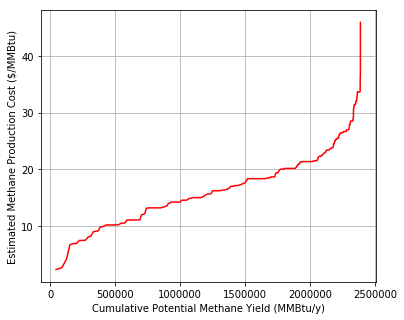

In [5]:
#Plot Cost vs Yield
yColName = 'Estimated Methane Production Cost ($/MMBtu)'
xColName = 'Cumulative Potential Methane Yield (MMBtu/y)'
x = dfDuplin[xColName]
y = dfDuplin[yColName]
plt.figure(figsize=(6,5))
plt.plot(x,y,'r-')
plt.xlabel(xColName)
plt.ylabel(yColName)
plt.grid()
plt.show()